In [ ]:
from google.colab import files
uploaded = files.upload()
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving dummy_npi_data.xlsx - Dataset.csv to dummy_npi_data.xlsx - Dataset.csv
User uploaded file "dummy_npi_data.xlsx - Dataset.csv" with length 78973 bytes


In [ ]:
import pandas as pd
# Load the dataset
df = pd.read_csv('dummy_npi_data.xlsx - Dataset.csv')
# Display basic info about the dataset
print("Dataset Info:")
df.info()
# Display the first 5 rows of the dataset
print("\nFirst 5 Rows:")
print(df.head())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   NPI                       1000 non-null   int64 
 1   State                     1000 non-null   object
 2   Login Time                1000 non-null   object
 3   Logout Time               1000 non-null   object
 4   Usage Time (mins)         1000 non-null   int64 
 5   Region                    1000 non-null   object
 6   Speciality                1000 non-null   object
 7   Count of Survey Attempts  1000 non-null   int64 
dtypes: int64(3), object(5)
memory usage: 62.6+ KB

First 5 Rows:
          NPI State           Login Time          Logout Time  \
0  1000000000    NY  2025-03-08 06:09:00  2025-03-08 06:28:00   
1  1000000001    MI  2025-03-08 12:28:00  2025-03-08 13:10:00   
2  1000000002    CA  2025-03-08 15:11:00  2025-03-08 15:37:00   
3  1000000003  

In [ ]:
# Convert Login Time and Logout Time to datetime
df['Login Time'] = pd.to_datetime(df['Login Time'])
df['Logout Time'] = pd.to_datetime(df['Logout Time'])
# Extract hour from login/logout time
df['Login Hour'] = df['Login Time'].dt.hour
df['Logout Hour'] = df['Logout Time'].dt.hour

In [ ]:
# Check the most common login/logout hours
print("Most common login hours:")
print(df['Login Hour'].value_counts().sort_index())
print("\nMost common logout hours:")
print(df['Logout Hour'].value_counts().sort_index())

Most common login hours:
Login Hour
6     78
7     71
8     60
9     68
10    59
11    71
12    76
13    81
14    58
15    70
16    53
17    63
18    57
19    60
20    75
Name: count, dtype: int64

Most common logout hours:
Logout Hour
6     18
7     57
8     65
9     63
10    68
11    63
12    61
13    87
14    74
15    65
16    62
17    57
18    56
19    66
20    63
21    50
22    25
Name: count, dtype: int64


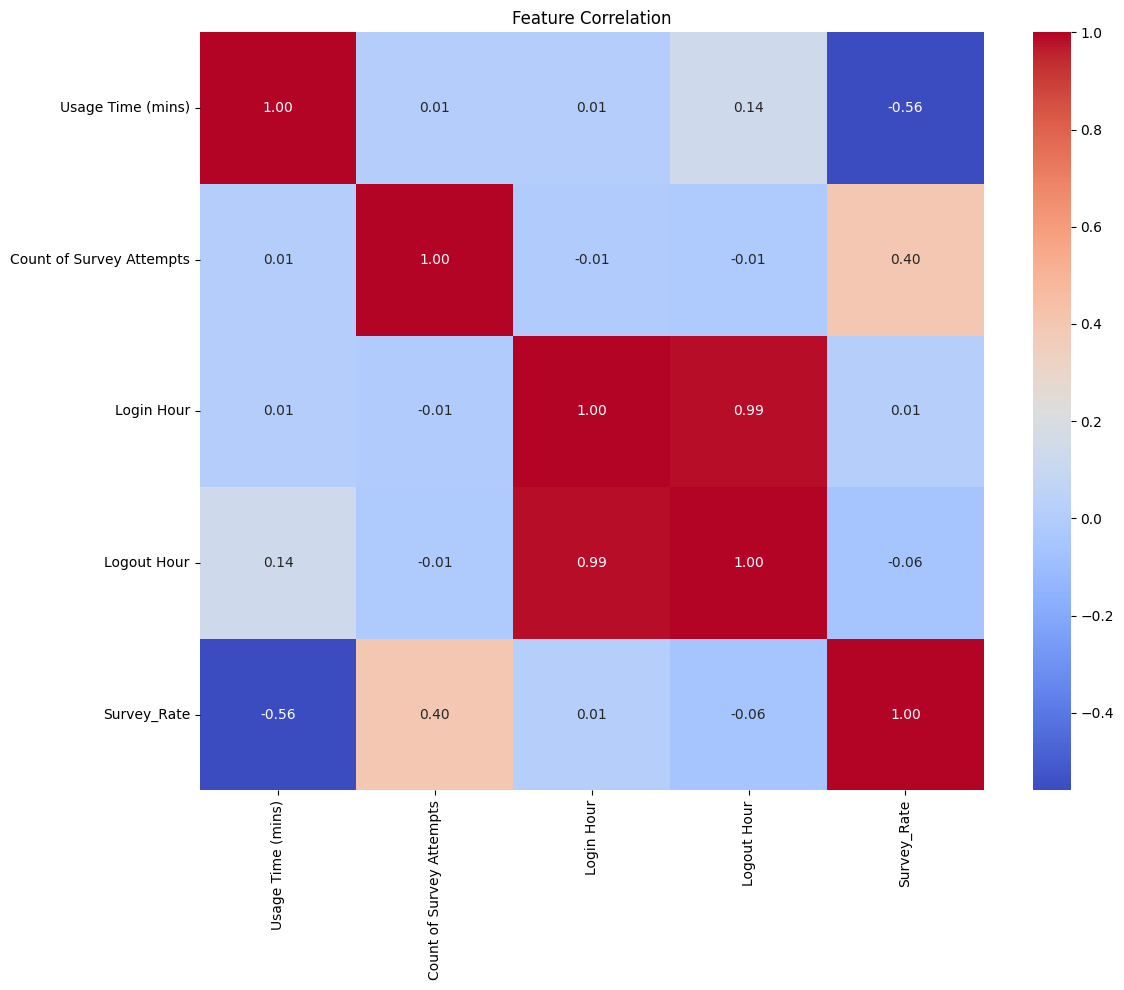

<Figure size 1200x600 with 0 Axes>

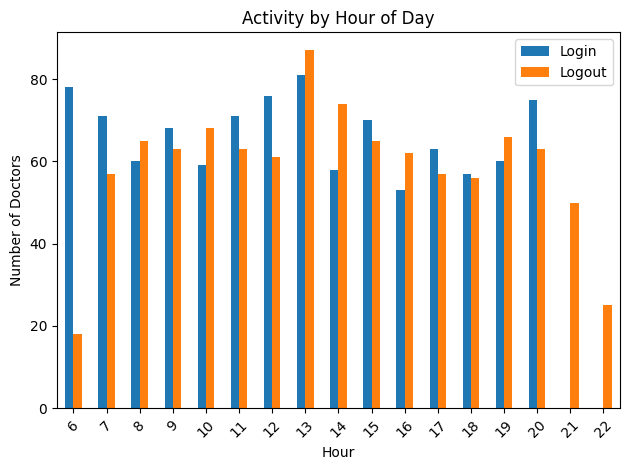

In [ ]:
# 1. Feature correlation heatmap
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 10))
correlation = df[['Usage Time (mins)', 'Count of Survey Attempts', 'Login Hour', 'Logout Hour', 'Survey_Rate']].corr()
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Feature Correlation')
plt.tight_layout()
plt.show()

# 2. Time of day activity visualization
activity_by_hour = pd.DataFrame({
    'Login': df['Login Hour'].value_counts().sort_index(),
    'Logout': df['Logout Hour'].value_counts().sort_index()
})
activity_by_hour.fillna(0, inplace=True)

plt.figure(figsize=(12, 6))
activity_by_hour.plot(kind='bar')
plt.title('Activity by Hour of Day')
plt.xlabel('Hour')
plt.ylabel('Number of Doctors')
plt.legend(['Login', 'Logout'])
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
# Create features that might be predictive
# Calculate the duration in minutes
import numpy as np
df['Duration'] = (df['Logout Time'] - df['Login Time']).dt.total_seconds() / 60

# Create a feature for survey attempt rate (attempts per minute)
df['Survey_Rate'] = df['Count of Survey Attempts'] / df['Usage Time (mins)']

# One-hot encode categorical variables
df_encoded = pd.get_dummies(df, columns=['State', 'Region', 'Speciality'], drop_first=True)

# Time features - create cyclic features for time to capture its circular nature
df_encoded['Login_Sin_Hour'] = np.sin(2 * np.pi * df['Login Hour']/24)
df_encoded['Login_Cos_Hour'] = np.cos(2 * np.pi * df['Login Hour']/24)
df_encoded['Logout_Sin_Hour'] = np.sin(2 * np.pi * df['Logout Hour']/24)
df_encoded['Logout_Cos_Hour'] = np.cos(2 * np.pi * df['Logout Hour']/24)

In [ ]:
# Define a target variable - let's consider doctors with above-median survey attempts as "active"
median_attempts = df['Count of Survey Attempts'].median()
df_encoded['Active_Participant'] = (df['Count of Survey Attempts'] > median_attempts).astype(int)

In [ ]:
# PCA
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Select numerical features for PCA
numerical_cols = ['Usage Time (mins)', 'Duration', 'Survey_Rate',
                  'Login_Sin_Hour', 'Login_Cos_Hour', 'Logout_Sin_Hour', 'Logout_Cos_Hour']

# Add any other numeric columns that were created during one-hot encoding

# Standardize the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df_encoded[numerical_cols])

# Apply PCA
pca = PCA(n_components=3)  # You can adjust this number
pca_result = pca.fit_transform(scaled_features)

# Add PCA components to dataframe
df_encoded['PCA_1'] = pca_result[:, 0]
df_encoded['PCA_2'] = pca_result[:, 1]
df_encoded['PCA_3'] = pca_result[:, 2]

# Print explained variance ratio
print("Explained variance ratio:", pca.explained_variance_ratio_)
print("Total explained variance:", sum(pca.explained_variance_ratio_))

Explained variance ratio: [0.38516735 0.33869504 0.18967306]
Total explained variance: 0.9135354481394901


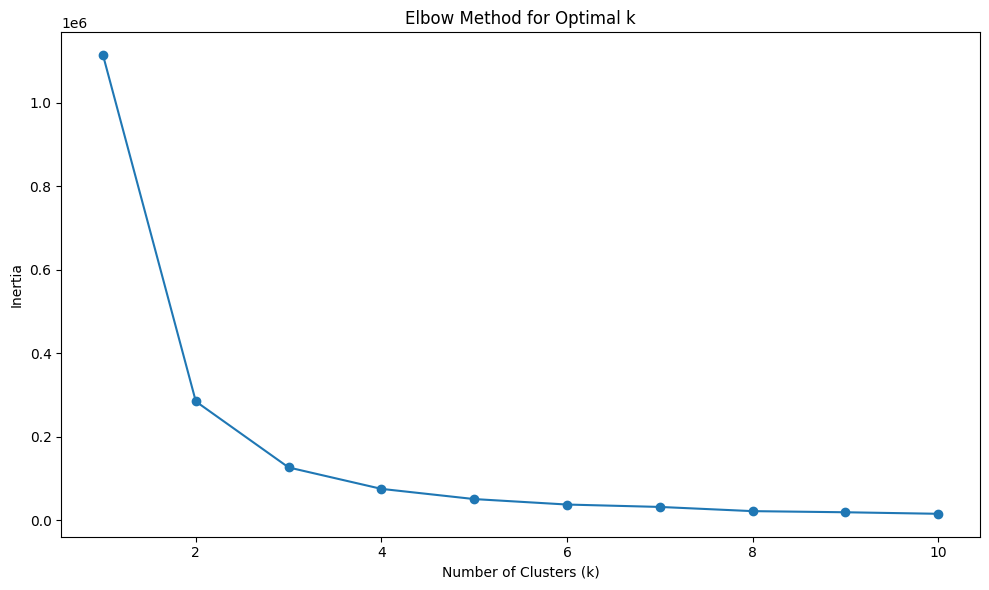

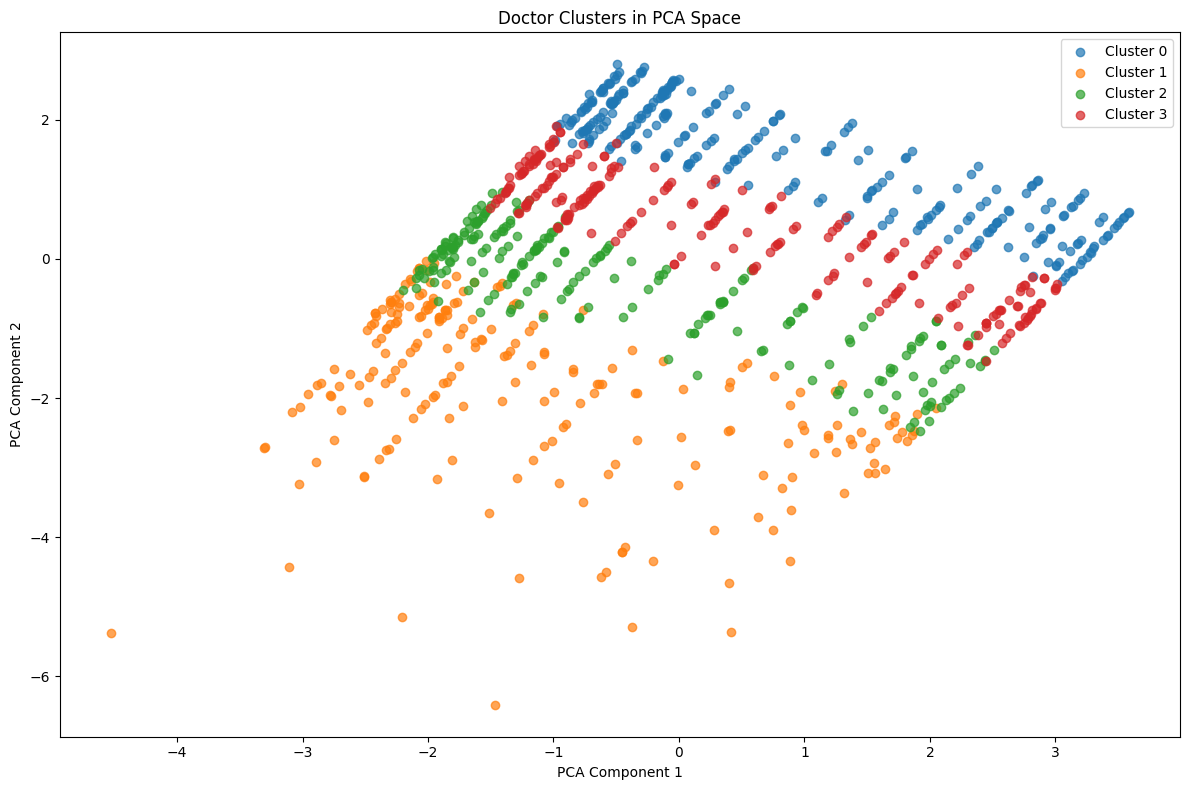

Cluster Characteristics:
   Cluster  Count of Survey Attempts  Usage Time (mins)  Survey_Rate  \
0        0                  4.989726         104.489726     0.048216   
1        1                  4.807018          18.802632     0.337267   
2        2                  5.161702          47.948936     0.111187   
3        3                  5.000000          75.461224     0.066962   

   Login Hour  Logout Hour  
0   12.750000    14.486301  
1   12.701754    13.057018  
2   12.676596    13.438298  
3   13.232653    14.526531  


In [ ]:
# K-means clustering based on doctor behavior
from sklearn.cluster import KMeans

# Select features for clustering
cluster_features = df_encoded[['PCA_1', 'PCA_2', 'PCA_3', 'Survey_Rate', 'Usage Time (mins)']]

# Determine optimal number of clusters using the elbow method
inertia = []
k_range = range(1, 11)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(cluster_features)
    inertia.append(kmeans.inertia_)

# Plot elbow curve
plt.figure(figsize=(10, 6))
plt.plot(k_range, inertia, 'o-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.tight_layout()
plt.show()

# Apply K-means with optimal k (let's say k=4 based on elbow plot)
kmeans = KMeans(n_clusters=4, random_state=42)
df['Cluster'] = kmeans.fit_predict(cluster_features)

# Visualize clusters in PCA space
plt.figure(figsize=(12, 8))
for cluster in range(4):
    plt.scatter(
        df_encoded.loc[df['Cluster'] == cluster, 'PCA_1'],
        df_encoded.loc[df['Cluster'] == cluster, 'PCA_2'],
        label=f'Cluster {cluster}',
        alpha=0.7
    )
plt.title('Doctor Clusters in PCA Space')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.tight_layout()
plt.show()

# Analyze cluster characteristics
cluster_analysis = df.groupby('Cluster').agg({
    'Count of Survey Attempts': 'mean',
    'Usage Time (mins)': 'mean',
    'Survey_Rate': 'mean',
    'Login Hour': 'mean',
    'Logout Hour': 'mean'
}).reset_index()

print("Cluster Characteristics:")
print(cluster_analysis)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Prepare feature set
# Use a mix of PCA components and other important features
X = df_encoded[['PCA_1', 'PCA_2', 'PCA_3', 'Survey_Rate', 'Usage Time (mins)',
                'Login_Sin_Hour', 'Login_Cos_Hour', 'Logout_Sin_Hour', 'Logout_Cos_Hour']]
y = df_encoded['Active_Participant']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Train a Random Forest model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Evaluate the model
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

# Feature importance
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': model.feature_importances_
}).sort_values(by='Importance', ascending=False)
print("Feature Importance:")
print(feature_importance)

              precision    recall  f1-score   support

           0       0.98      0.93      0.95       134
           1       0.92      0.98      0.95       116

    accuracy                           0.95       250
   macro avg       0.95      0.95      0.95       250
weighted avg       0.95      0.95      0.95       250

Feature Importance:
             Feature  Importance
3        Survey_Rate    0.619489
4  Usage Time (mins)    0.149717
1              PCA_2    0.081785
0              PCA_1    0.054649
2              PCA_3    0.047330
8    Logout_Cos_Hour    0.013558
7    Logout_Sin_Hour    0.012514
5     Login_Sin_Hour    0.011660
6     Login_Cos_Hour    0.009299


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Prepare feature set
# Use a mix of PCA components and other important features
X = df_encoded[['PCA_1', 'PCA_2', 'PCA_3', 'Survey_Rate', 'Usage Time (mins)',
                'Login_Sin_Hour', 'Login_Cos_Hour', 'Logout_Sin_Hour', 'Logout_Cos_Hour']]
y = df_encoded['Active_Participant']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Train a Random Forest model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Evaluate the model
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

# Feature importance
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': model.feature_importances_
}).sort_values(by='Importance', ascending=False)
print("Feature Importance:")
print(feature_importance)

              precision    recall  f1-score   support

           0       0.98      0.93      0.95       134
           1       0.92      0.98      0.95       116

    accuracy                           0.95       250
   macro avg       0.95      0.95      0.95       250
weighted avg       0.95      0.95      0.95       250

Feature Importance:
             Feature  Importance
3        Survey_Rate    0.619489
4  Usage Time (mins)    0.149717
1              PCA_2    0.081785
0              PCA_1    0.054649
2              PCA_3    0.047330
8    Logout_Cos_Hour    0.013558
7    Logout_Sin_Hour    0.012514
5     Login_Sin_Hour    0.011660
6     Login_Cos_Hour    0.009299


In [ ]:
def predict_active_doctors_at_hour(hour, df_original, model, top_n=20):
    """
    Predict which doctors are most likely to be active at a given hour

    Args:
        hour (int): Hour of the day (0-23)
        df_original (DataFrame): Original dataframe with all doctor data
        model (object): Trained machine learning model
        top_n (int): Number of top doctors to return

    Returns:
        DataFrame: Top doctors most likely to participate
    """
    # Create a copy of the original dataframe to work with
    df_copy = df_original.copy()

    # Create an array where all doctors have the same input hour
    # We'll use this to predict which doctors are active at this specific hour

    # Create cyclic time features for the input hour
    sin_hour = np.sin(2 * np.pi * hour/24)
    cos_hour = np.cos(2 * np.pi * hour/24)

    # For each doctor, set the login and logout hour features to the input hour
    # Create a feature matrix for prediction
    X_hour = []

    for _, row in df_copy.iterrows():
        # Get existing PCA features and other important features for this doctor
        pca1 = df_encoded.loc[_, 'PCA_1']
        pca2 = df_encoded.loc[_, 'PCA_2']
        pca3 = df_encoded.loc[_, 'PCA_3']
        survey_rate = df_encoded.loc[_, 'Survey_Rate']
        usage_time = df_encoded.loc[_, 'Usage Time (mins)']

        # Create a feature vector with the time replaced by the input hour
        features = [pca1, pca2, pca3, survey_rate, usage_time,
                   sin_hour, cos_hour, sin_hour, cos_hour]  # Use the input hour for both login/logout

        X_hour.append(features)

    X_hour = np.array(X_hour)

    # Get prediction probabilities for each doctor
    probs = model.predict_proba(X_hour)[:, 1]  # Probability of being active

    # Add probabilities to the dataframe
    df_copy['Active_Probability'] = probs

    # Sort by probability and return top N doctors
    top_doctors = df_copy.sort_values('Active_Probability', ascending=False).head(top_n)
    return top_doctors[['NPI', 'State', 'Region', 'Speciality', 'Active_Probability']]

# Example usage of the function
hour_input = 10  # Example: 9 AM
top_doctors = predict_active_doctors_at_hour(hour_input, df, model)
print(f"\nTop doctors most likely to participate at {hour_input}:00:")
print(top_doctors)


Top doctors most likely to participate at 10:00:
            NPI State     Region        Speciality  Active_Probability
480  1000000480    GA       West  General Practice                1.00
417  1000000417    GA      South         Radiology                1.00
921  1000000921    OH      South        Cardiology                1.00
290  1000000290    IL  Northeast          Oncology                1.00
632  1000000632    FL      South          Oncology                1.00
681  1000000681    GA       West         Neurology                1.00
669  1000000669    IL       West        Pediatrics                1.00
336  1000000336    FL      South        Pediatrics                1.00
476  1000000476    IL    Midwest  General Practice                0.99
546  1000000546    OH       West        Cardiology                0.99
343  1000000343    MI  Northeast        Cardiology                0.99
354  1000000354    CA      South          Oncology                0.99
694  1000000694    MI  Nort

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
